      Price     Qty_  Sub_Total  Discount       Tax  Final_Total   Covers  \
0 -0.435569  0.48601    -0.0261 -0.041875 -0.201004    -0.036475 -0.89394   
1 -0.435569  0.48601    -0.0261 -0.041875 -0.201004    -0.036475 -0.89394   
2 -0.435569  0.48601    -0.0261 -0.041875 -0.201004    -0.036475 -0.89394   
3 -0.435569  0.48601    -0.0261 -0.041875 -0.201004    -0.036475 -0.89394   
4 -0.435569  0.48601    -0.0261 -0.041875 -0.201004    -0.036475 -0.89394   

   Non_Taxable  CGST_Rate  CGST_Amount  SGST_Rate  SGST_Amount  VAT_Rate  \
0    -0.231634        0.0    -0.401017        0.0    -0.400927       0.0   
1    -0.231634        0.0    -0.401017        0.0    -0.400927       0.0   
2    -0.231634        0.0    -0.401017        0.0    -0.400927       0.0   
3    -0.231634        0.0    -0.401017        0.0    -0.400927       0.0   
4    -0.231634        0.0    -0.401017        0.0    -0.400927       0.0   

   VAT_Amount  Service_Charge_Rate  Service_Charge_Amount  Cluster Severity  
0 

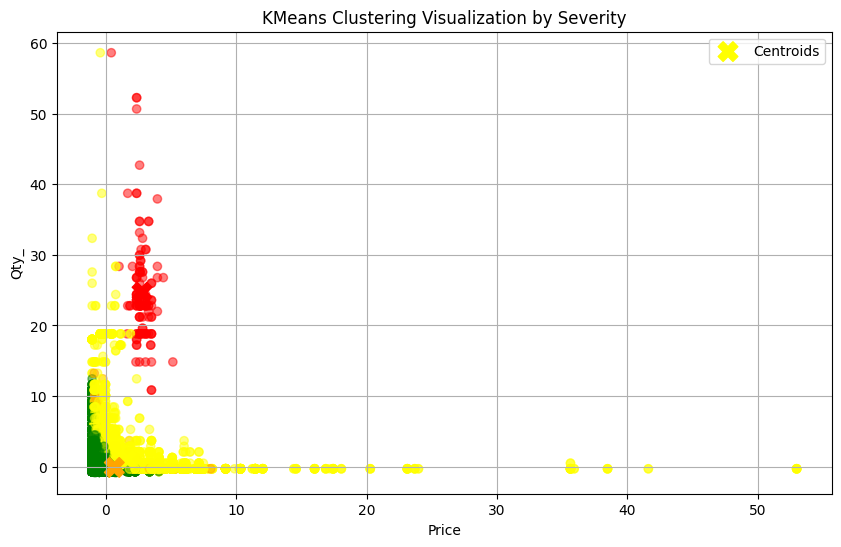

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import numpy as np
import matplotlib.pyplot as plt

# Generalized function for clustering with severity-based labeling
def clustering_with_severity(data, n_clusters=4):
    # Select only numerical columns for clustering
    features = data.select_dtypes(include=[np.number]).columns.tolist()

    # Standardize the features for clustering
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data[features])

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data['Cluster'] = kmeans.fit_predict(data_scaled)
    
    # Get cluster sizes to determine the largest (green) cluster
    cluster_sizes = data['Cluster'].value_counts()
    green_cluster = cluster_sizes.idxmax()  # The largest cluster

    # Get centroids of each cluster
    centroids = kmeans.cluster_centers_
    
    # Calculate the distance of each cluster centroid to the 'green' centroid
    green_centroid = centroids[green_cluster]
    distances = np.array([euclidean(centroid, green_centroid) for centroid in centroids])
    
    # Assign severity labels based on the distances
    severity_labels = ['green', 'yellow', 'orange', 'red']
    sorted_clusters_by_distance = np.argsort(distances)  # Sort clusters by distance

    # Map clusters to severity levels (green -> yellow -> orange -> red)
    cluster_to_severity = {sorted_clusters_by_distance[i]: severity_labels[i] for i in range(n_clusters)}
    
    # Add the severity label column to the original data
    data['Severity'] = data['Cluster'].map(cluster_to_severity)

    return data, cluster_to_severity, distances, centroids  # Return additional info

# Load your data
df = pd.read_csv('./merged_data.csv')  

# Run the clustering with severity labeling using all numerical columns
df_with_severity, cluster_map, cluster_distances, centroids = clustering_with_severity(df)

# Save the resulting DataFrame with severity levels
df_with_severity.to_csv('data_with_severity.csv', index=False)

# Output the result
print(df_with_severity.head())
print("\nCluster to Severity Mapping:", cluster_map)
print("\nCluster Distances from Green Cluster:", cluster_distances)

# Visualization of the clusters based on severity
features = df.select_dtypes(include=[np.number]).columns.tolist()
if len(features) >= 2:
    plt.figure(figsize=(10, 6))

    # Define the plotting function
    def plot_clusters_with_severity(df_with_severity, features, centroids, cluster_to_severity):
        color_map = {'green': 'green', 'yellow': 'yellow', 'orange': 'orange', 'red': 'red'}
        colors = df_with_severity['Severity'].map(color_map)

        plt.scatter(df_with_severity[features[0]], df_with_severity[features[1]], c=colors, alpha=0.5)

        # Plot centroids colored by their severity
        centroid_severity = [cluster_to_severity[i] for i in range(len(centroids))]
        centroid_colors = [color_map[severity] for severity in centroid_severity]
        
        plt.scatter(centroids[:, 0], centroids[:, 1], c=centroid_colors, marker='X', s=200, label='Centroids')

        # Customize the plot
        plt.title('KMeans Clustering Visualization by Severity')
        plt.xlabel(features[0])
        plt.ylabel(features[1])
        plt.legend()
        plt.grid()

        # Call the plotting function
    plot_clusters_with_severity(df_with_severity, features, centroids, cluster_map)
    plt.show()
else:
    print("Not enough numerical features for visualization.")
